In [1]:
import os
import shapely
import matplotlib.pyplot as plt
import cartopy
from solar_utils import daynight_grid, sun_pos
import numpy as np
import cartopy.crs as ccrs
from skyfield.api import load
from tqdm import tqdm
from ground_path import ground_path

In [2]:
resource_url = 'http://celestrak.com/NORAD/elements/resource.txt'

In [3]:
fname = 'tle.txt'
if os.path.isfile(fname):
    os.remove(fname)

satellites = load.tle(resource_url, filename=fname, reload=True)

[#################################] 100% tle.txt


In [4]:
satellite = satellites['HODOYOSHI-1']
print(satellite)

EarthSatellite 'HODOYOSHI-1' number=40299 epoch=2018-08-05T01:53:53Z


In [5]:
satellite.epoch.utc_datetime()

datetime.datetime(2018, 8, 5, 1, 53, 52, 575000, tzinfo=<UTC>)

## Calculate ground path

In [6]:
df_hodoyoshi = ground_path(satellite, '2018-08-01T05:00:00', '2018-08-01T23:00:00', '1min')
df_hodoyoshi.head()

100%|██████████| 1081/1081 [00:01<00:00, 631.97it/s]


,elevation,lon,lat,orbit,geometry
datetime,,,,,
2018-08-01 05:00:00,497.008045,98.941205,52.095727,0,POINT (98.9412054073252 52.09572653257874)
2018-08-01 05:01:00,496.551416,97.498534,48.357022,0,POINT (97.49853442715047 48.35702171815784)
2018-08-01 05:02:00,496.133730,96.218769,44.605339,0,POINT (96.21876874648248 44.60533875717626)
2018-08-01 05:03:00,495.772643,95.063713,40.843217,0,POINT (95.06371260306418 40.84321708201787)
2018-08-01 05:04:00,495.485588,94.005640,37.072556,0,POINT (94.00564048329181 37.07255568480121)


## Visualization

In [7]:
def plot_satellite(df, satellite, output=None, show=True, figsize=(14,8)):    
    dt = df.index[-1]

    fig = plt.figure(figsize=figsize)

    ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
    ax.set_global()

    # plot map with features
    ax.stock_img()
    ax.coastlines()
    ax.add_feature(cartopy.feature.BORDERS, linestyle='-', alpha=.5)

    # plot orbits
    for orbit in df['orbit'].cat.categories:
        mask = df['orbit'] == orbit
        ax.plot(df[mask]['lon'], df[mask]['lat'], label='Orbit {:}'.format(orbit))

    # plot satellite starting position
    ax.plot(df.iloc[0]['lon'], df.iloc[0]['lat'], color='green', markersize=10, markeredgecolor='black', marker='o', alpha=0.5)
    ax.plot(df.iloc[-1]['lon'], df.iloc[-1]['lat'], color='red', markersize=10, markeredgecolor='black', marker='o', alpha=0.5)

    # plot sun position
    lat, lng = sun_pos(dt=dt)
    ax.plot([lng], [lat], color='black', marker='$☉$', markersize=20, alpha=0.5)

    # draw daynight
    lons,lats,daynight = daynight_grid(date=dt, delta=0.25, lonmin=-180, lonmax=180)
    ax.contourf(lons, lats, daynight, 1, colors=['k'], alpha=0.5)

    #ax.gridlines()
    ax.set_title("{:} - orbits\n {:} ~ {:}".format(satellite.name, df.index.min(), df.index.max()))
    ax.legend(loc='upper left')
    
    if output:
        plt.savefig(output)
    
    if show:
        plt.show()

    plt.clf()
    plt.cla()
    plt.close()

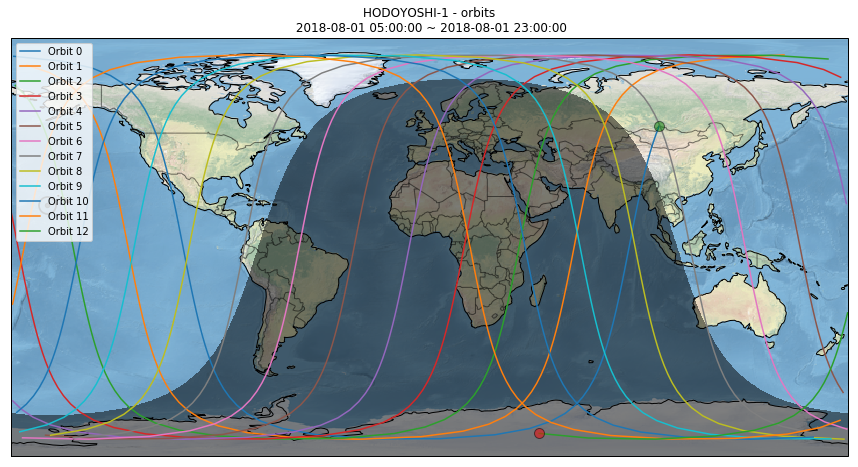

In [8]:
deg = np.round(180 - np.rad2deg(satellite.model.inclo)).astype(int)

frames_directory = './frames'
if not os.path.exists(frames_directory):
    os.makedirs(frames_directory)

plot_satellite(df_hodoyoshi, satellite, output=frames_directory + '/hodoyoshi1_{:}deg.jpg'.format(deg), show=True, figsize=(15,10))

---

## Generate simulations of various orbit inclinations

In [9]:
from subprocess import Popen, PIPE
import argparse

def make_video(in_dir, out_dir):
    p = Popen(['./make_video.sh "{:}" "{:}"'.format(in_dir, out_dir)], stdin=PIPE, stdout=PIPE, stderr=PIPE, shell=True)
    output, err = p.communicate()
    print(p.returncode)
    #print(output.decode('utf-8'), err.decode('utf-8'))
    del p
    return None

In [10]:
videos_directory = './videos'
if not os.path.exists(videos_directory):
    os.makedirs(videos_directory)

  4%|▍         | 60/1441 [00:00<00:02, 594.67it/s]

Inclination 0 degrees


100%|██████████| 288/288 [01:32<00:00,  3.12it/s]


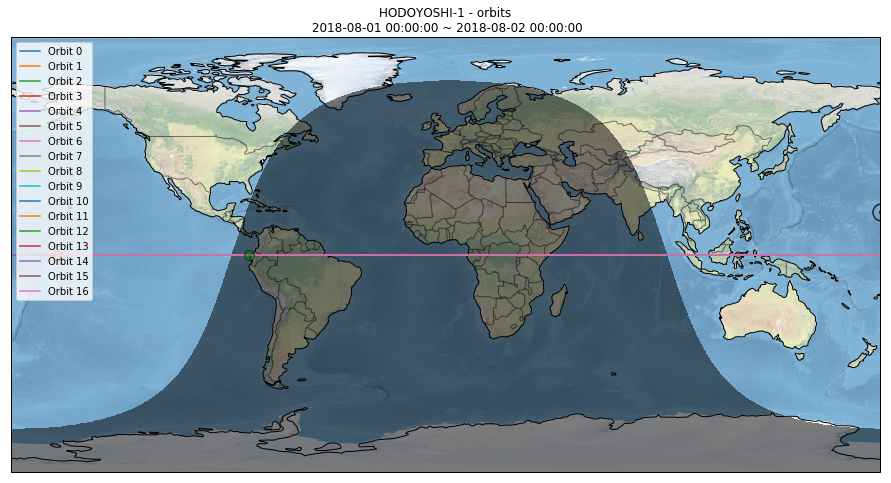

  4%|▍         | 64/1441 [00:00<00:02, 631.36it/s]

0
Inclination 45 degrees


100%|██████████| 288/288 [01:28<00:00,  3.24it/s]


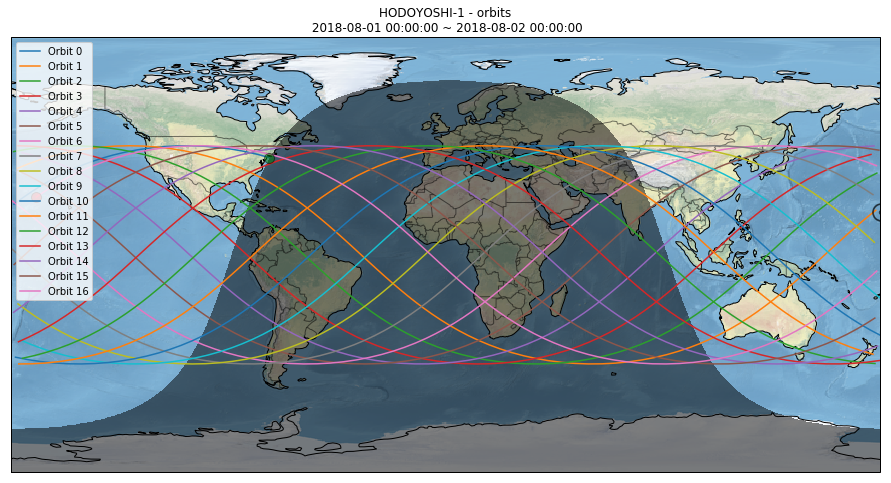

  4%|▍         | 64/1441 [00:00<00:02, 634.03it/s]

0
Inclination 90 degrees


100%|██████████| 288/288 [01:29<00:00,  3.22it/s]


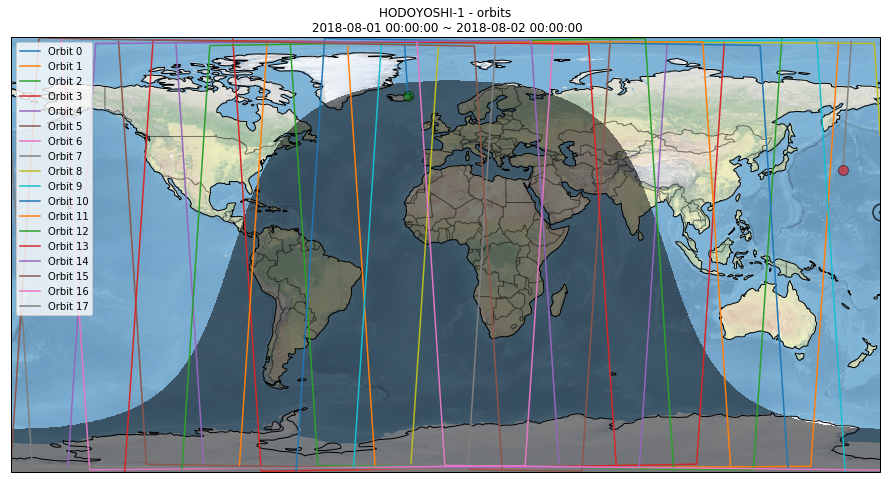

0


In [11]:
for deg in [0, 45, 90]:
    print('Inclination {:} degrees'.format(deg))

    satellite.model.inclo = np.deg2rad(180 - deg)
    df_hodoyoshi = ground_path(satellite, '2018-08-01T00:00:00', '2018-08-02T00:00:00', '1min')

    for i in tqdm(range(1, len(df_hodoyoshi), 5)):
        df_sub = df_hodoyoshi.iloc[:i]
        dt = df_sub.index[-1]
        plot_satellite(df_sub, satellite, output=frames_directory + '/{:}deg_{:%Y%m%d%H%M%S}.jpg'.format(deg, dt), show=False, figsize=(16,8))
    
    plot_satellite(df_hodoyoshi, satellite, output=frames_directory + '/hodoyoshi1_{:}deg.jpg'.format(deg), show=True, figsize=(16,8))
    make_video(frames_directory + '/{:}deg_*.jpg'.format(deg), videos_directory + '/hodoyoshi1_{:}deg.mp4'.format(deg))

In [12]:
%%HTML
<video controls>
  <source src="./videos/hodoyoshi1_45deg.mp4" type="video/mp4">
</video>

## Sources

- https://en.wikipedia.org/wiki/Simplified_perturbations_models
- http://rhodesmill.org/skyfield/
- https://en.wikipedia.org/wiki/Terminator_%28solar%29
- https://github.com/SciTools/cartopy